In [135]:
import numpy as np
from sympy import symbols, Matrix
from scipy.integrate import solve_ivp
import scipy.linalg as la
import matplotlib.pylab as plt

In [145]:
tspan = np.linspace(0, 100, 100)
tshift = 4.79

def sortEig(A):
    l, v = la.eig(A)
    idx = np.argsort(np.abs(l))
    l_sorted = l[idx]
    v_sorted = v[:, idx]
    return l_sorted, v_sorted

def ode_system(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P = y 
    sum_n345 = n3 + n4 + n5
    CC_A = 1 - sum_n345 / KA
    CC_R = 1 - sum_n345 / KR
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3*CC_A - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4*CC_R - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5*CC_R - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

#def ode_system_linear(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta, damp1 = 1, damp2 = 1, damp3 = 1, damp4 = 1, damp5 = 1, damp6 = 1):
#    n1, n2, n3, n4, n5, P = y * [damp1, damp2, damp3, damp4, damp5, damp6]
#    dn1dt = - (R12 + R14)*n1
#    dn2dt = R12*n1 - (R23 + R25)*n2
#    dn3dt = R23*n2 - R36*n3 + gamma3*n3 - delta*n3
#    dn4dt = R14*n1 - R45*n4 + gamma4*n4 - delta*n4
#    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5 - delta*n5
#    dPdt = (R56*n5 + R36*n3)*(1-P)
#    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

def ode_system_linear(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P = y
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3 - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4 - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5 - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

N_crypts = 1e+7
r1 = 204
u = 10e-7 * r1
mu = 10e-9 * r1
gamma3 = 0.2
gamma4 = 0.07
gamma5 = 0.07
delta = 0.05
KA = 1000
KR = 17

values = {
    "R12": 2 * u,
    "R14": mu,
    "R23": u,
    "R25": mu,
    "R36": mu,
    "R45": 2 * u,
    "R56": u,
    "N_crypts": N_crypts,
    "K_A": KA,
    "K_R": KR,
    "gamma_3": gamma3,
    "gamma_4": gamma4,
    "gamma_5": gamma5,
    "delta": delta,
}

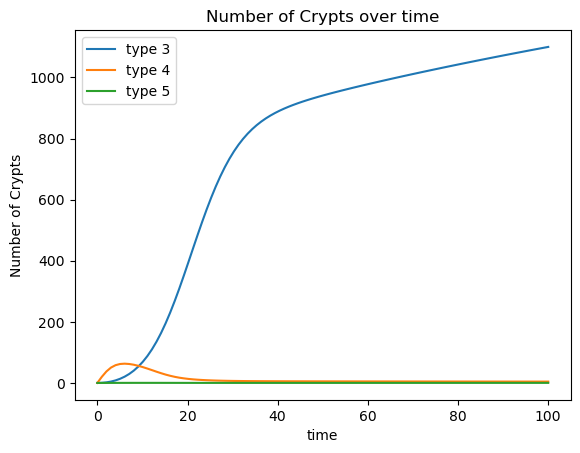

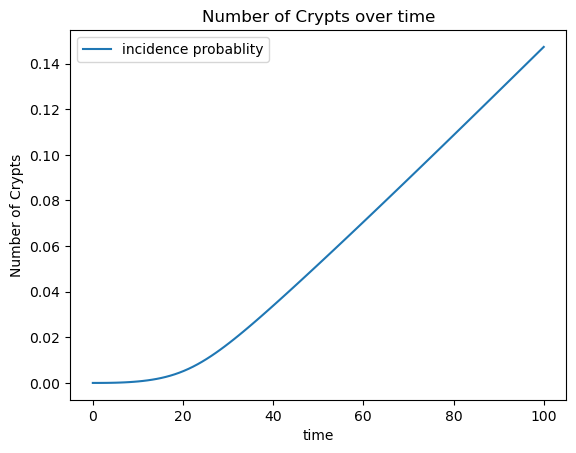

In [146]:
sol = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

# plt.plot(sol.t, sol.y[0,:], label='1') # this is too big to plot
# plt.plot(sol.t, sol.y[1,:], label="type 2") # linear growth
plt.plot(sol.t, sol.y[2,:], label="type 3")
plt.plot(sol.t, sol.y[3,:], label="type 4")
plt.plot(sol.t, sol.y[4,:], label="type 5")
# plt.plot(sol.t, sol.y[5,:], label='incidence probablity')
plt.xlabel('time')
plt.ylabel('Number of Crypts')
plt.legend(loc='upper left')
plt.title("Number of Crypts over time")
plt.savefig('Simulation.png')
plt.show()

plt.plot(sol.t, sol.y[5,:], label='incidence probablity')
plt.xlabel('time')
plt.ylabel('Number of Crypts')
plt.legend(loc='upper left')
plt.title("Number of Crypts over time")
plt.savefig('SimulationIncidenceProbabililty.png')
plt.show()


Case 1: SSE = 0.019120749041129658
Case 2: SSE = 0.016523370684762156
Case 3: SSE = 0.4299115426472375
Case 4: SSE = 0.0001482744679677225
Case 5: SSE = 0.0004891028858384452
Case 6: SSE = 0.5403612171228813


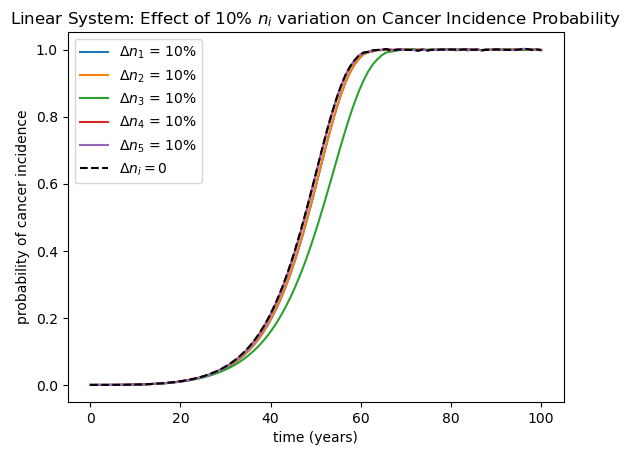

In [140]:
# OLD simulated variation in linear ode system
### TO DO: Make sure the 1% variation is only in the term for n_3 --> n_3
### Maybe instead of varying for each n_i, we have to vary for each nonzero transition? (n_1-->n_2, n_3-->n_3, etc.)
print()
sol_0 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 1, 1))
sol_1 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 0.9, 1, 1, 1, 1, 1))
sol_2 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 0.9, 1, 1, 1, 1))
sol_3 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 0.9, 1, 1, 1))
sol_4 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 0.9, 1, 1))
sol_5 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 0.9, 1))
sol_6 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 1, 0.9))

# Compute SSE (Sum of Squared Errors) for each case. Notice the less the SSE the less the perturbation due to varying parameters. So we are looking for the max deviation.
SSEs = []
for i, sol_case in enumerate([sol_1, sol_2, sol_3, sol_4, sol_5, sol_6], start=1):
    sse = np.sum((sol_0.y[5, :] - sol_case.y[5, :]) ** 2)
    print(f"Case {i}: SSE = {sse}")
    SSEs.append(sse)

plt.plot(sol.t, sol_1.y[5, :], label=fr'$\Delta n_1$ = 10%')
plt.plot(sol.t, sol_2.y[5, :], label=fr'$\Delta n_2$ = 10%')
plt.plot(sol.t, sol_3.y[5, :], label=fr'$\Delta n_3$ = 10%')
plt.plot(sol.t, sol_4.y[5, :], label=fr'$\Delta n_4$ = 10%')
plt.plot(sol.t, sol_5.y[5, :], label=fr'$\Delta n_5$ = 10%')
plt.plot(sol.t, sol_0.y[5,:], label=fr'$\Delta n_i = 0$', linestyle='--', color='black')

plt.xlabel('time (years)')
plt.ylabel('probability of cancer incidence')
plt.legend(loc='upper left')
plt.title("Linear System: Effect of 10% $n_i$ variation on Cancer Incidence Probability")
plt.savefig('LinearSensitivity.png')
plt.show()


Case 1: SSE = 0.019120749041124905
Case 2: SSE = 0.01650163382090774
Case 3: SSE = 0.00010194664421382497
Case 4: SSE = 0.016523370684752528
Case 5: SSE = 0.014605796647471591
Case 6: SSE = 6.588787448535669e-05
Case 7: SSE = 0.39715176610953895
Case 8: SSE = 0.02918774608454518
Case 9: SSE = 0.00010109781810331683
Case 10: SSE = 0.02544876133915362


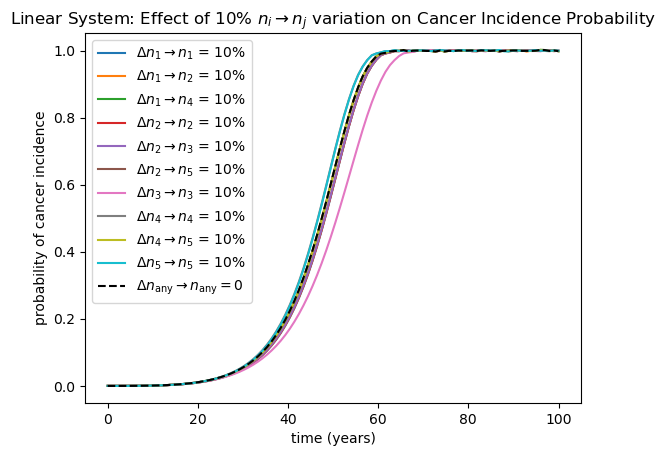

In [157]:
# NEW simulated variation in linear ode system
print()

vary = 0.9
sol_0 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_11 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_12 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_14 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_22 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_23 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_25 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_33 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu*vary, 2*u, u, KA, KR, gamma3*vary, gamma4, gamma5, delta*vary))

sol_44 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4*vary, gamma5, delta*vary))
sol_45 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_55 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u*vary, KA, KR, gamma3, gamma4, gamma5*vary, delta*vary))

# Compute SSE (Sum of Squared Errors) for each case. Notice the less the SSE the less the perturbation due to varying parameters. So we are looking for the max deviation.
SSEs = []
for i, sol_case in enumerate([sol_11, sol_12, sol_14, sol_22, sol_23, sol_25, sol_33, sol_44, sol_45, sol_55], start=1):
    sse = np.sum((sol_0.y[5, :] - sol_case.y[5, :]) ** 2)
    print(f"Case {i}: SSE = {sse}")
    SSEs.append(sse)

plt.plot(sol.t, sol_11.y[5, :], label=fr'$\Delta n_1 \rightarrow n_1$ = 10%')
plt.plot(sol.t, sol_12.y[5, :], label=fr'$\Delta n_1 \rightarrow n_2$ = 10%')
plt.plot(sol.t, sol_14.y[5, :], label=fr'$\Delta n_1 \rightarrow n_4$ = 10%')
plt.plot(sol.t, sol_22.y[5, :], label=fr'$\Delta n_2 \rightarrow n_2$ = 10%')
plt.plot(sol.t, sol_23.y[5, :], label=fr'$\Delta n_2 \rightarrow n_3$ = 10%')
plt.plot(sol.t, sol_25.y[5, :], label=fr'$\Delta n_2 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_33.y[5, :], label=fr'$\Delta n_3 \rightarrow n_3$ = 10%')
plt.plot(sol.t, sol_44.y[5, :], label=fr'$\Delta n_4 \rightarrow n_4$ = 10%')
plt.plot(sol.t, sol_45.y[5, :], label=fr'$\Delta n_4 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_55.y[5, :], label=fr'$\Delta n_5 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_0.y[5,:], label=fr'$\Delta n_{{\mathrm{{any}}}} \rightarrow n_{{\mathrm{{any}}}} = 0$', linestyle='--', color='black')

plt.xlabel('time (years)')
plt.ylabel('probability of cancer incidence')
plt.legend(loc='upper left')
plt.title(fr"Linear System: Effect of 10% $n_i \rightarrow n_j$ variation on Cancer Incidence Probability")
plt.savefig('LinearSensitivity.png')
plt.show()

Case 1: SSE = 0.00039179136644783345
Case 2: SSE = 0.00042212347166715216
Case 3: SSE = 0.00047873037011909403
Case 4: SSE = 1.5711252338549054e-09
Case 5: SSE = 1.0927801570146802e-08
Case 6: SSE = 2.0226432959447393e-05
+--------+-------------+
| Case   |         SSE |
+========+=============+
| $n_1$  | 0.000391791 |
+--------+-------------+
| $n_2$  | 0.000422123 |
+--------+-------------+
| $n_3$  | 0.00047873  |
+--------+-------------+
| $n_4$  | 1.57113e-09 |
+--------+-------------+
| $n_5$  | 1.09278e-08 |
+--------+-------------+
| $n_6$  | 2.02264e-05 |
+--------+-------------+
Max SSE occurs at case 3, with value: 0.00047873037011909403


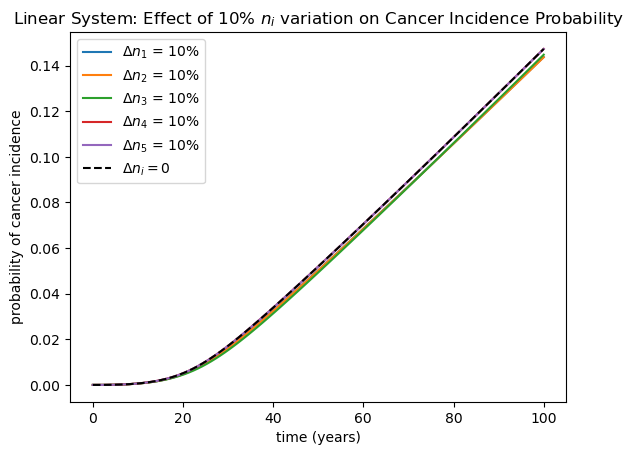

In [139]:
# OLD simulated variation in nonlinear ode system
sol_0 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 1, 1))
sol_1 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 0.9, 1, 1, 1, 1, 1))
sol_2 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 0.9, 1, 1, 1, 1))
sol_3 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 0.9, 1, 1, 1))
sol_4 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 0.9, 1, 1))
sol_5 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 0.9, 1))
sol_6 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 1, 0.9))

# Compute SSE (Sum of Squared Errors) for each case. Notice the less the SSE the less the perturbation due to varying parameters. So we are looking for the max deviation.
SSEs = []
for i, sol_case in enumerate([sol_1, sol_2, sol_3, sol_4, sol_5, sol_6], start=1):
    sse = np.sum((sol_0.y[5, :] - sol_case.y[5, :]) ** 2)
    print(f"Case {i}: SSE = {sse}")
    SSEs.append(sse)
    
max_SSE_value = max(SSEs)
max_SSE_case = SSEs.index(max_SSE_value) + 1  # Adding 1 to match the 1-based indexing in the print output

from tabulate import tabulate
data = list(zip(["$n_1$", "$n_2$", "$n_3$", "$n_4$", "$n_5$", "$n_6$"], SSEs))
headers = ["Case", "SSE"]
print(tabulate(data, headers=headers, tablefmt="grid"))

print(f"Max SSE occurs at case {max_SSE_case}, with value: {max_SSE_value}")

plt.plot(sol.t, sol_1.y[5, :], label=fr'$\Delta n_1$ = 10%')
plt.plot(sol.t, sol_2.y[5, :], label=fr'$\Delta n_2$ = 10%')
plt.plot(sol.t, sol_3.y[5, :], label=fr'$\Delta n_3$ = 10%')
plt.plot(sol.t, sol_4.y[5, :], label=fr'$\Delta n_4$ = 10%')
plt.plot(sol.t, sol_5.y[5, :], label=fr'$\Delta n_5$ = 10%')
plt.plot(sol.t, sol_0.y[5,:], label=fr'$\Delta n_i = 0$', linestyle='--', color='black')

plt.xlabel('time (years)')
plt.ylabel('probability of cancer incidence')
plt.legend(loc='upper left')
plt.title("Linear System: Effect of 10% $n_i$ variation on Cancer Incidence Probability")
plt.savefig('NonLinearSensitivity.png')
plt.show()


Case 1: SSE = 0.0003917913664478431
Case 2: SSE = 0.0004196018491858474
Case 3: SSE = 4.575725693563618e-07
Case 4: SSE = 0.00042212347166715726
Case 5: SSE = 0.0003750325879499056
Case 6: SSE = 1.3026661507327786e-06
Case 7: SSE = 0.004805818235386469
Case 8: SSE = 0.00026087477549362946
Case 9: SSE = 1.5966934536530722e-08
Case 10: SSE = 0.00028355586254262636


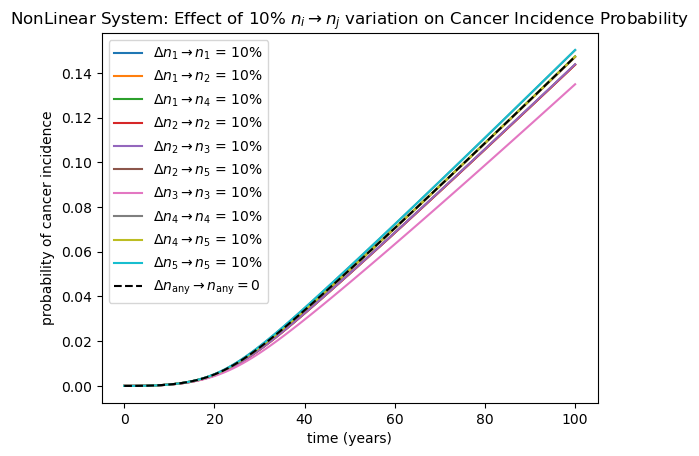

In [159]:
# NEW simulated variation in linear ode system
print()

vary = 0.9
sol_0 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_11 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_12 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_14 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_22 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_23 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_25 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_33 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu*vary, 2*u, u, KA, KR, gamma3*vary, gamma4, gamma5, delta*vary))

sol_44 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4*vary, gamma5, delta*vary))
sol_45 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_55 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u*vary, KA, KR, gamma3, gamma4, gamma5*vary, delta*vary))

# Compute SSE (Sum of Squared Errors) for each case. Notice the less the SSE the less the perturbation due to varying parameters. So we are looking for the max deviation.
SSEs = []
for i, sol_case in enumerate([sol_11, sol_12, sol_14, sol_22, sol_23, sol_25, sol_33, sol_44, sol_45, sol_55], start=1):
    sse = np.sum((sol_0.y[5, :] - sol_case.y[5, :]) ** 2)
    print(f"Case {i}: SSE = {sse}")
    SSEs.append(sse)

plt.plot(sol.t, sol_11.y[5, :], label=fr'$\Delta n_1 \rightarrow n_1$ = 10%')
plt.plot(sol.t, sol_12.y[5, :], label=fr'$\Delta n_1 \rightarrow n_2$ = 10%')
plt.plot(sol.t, sol_14.y[5, :], label=fr'$\Delta n_1 \rightarrow n_4$ = 10%')
plt.plot(sol.t, sol_22.y[5, :], label=fr'$\Delta n_2 \rightarrow n_2$ = 10%')
plt.plot(sol.t, sol_23.y[5, :], label=fr'$\Delta n_2 \rightarrow n_3$ = 10%')
plt.plot(sol.t, sol_25.y[5, :], label=fr'$\Delta n_2 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_33.y[5, :], label=fr'$\Delta n_3 \rightarrow n_3$ = 10%')
plt.plot(sol.t, sol_44.y[5, :], label=fr'$\Delta n_4 \rightarrow n_4$ = 10%')
plt.plot(sol.t, sol_45.y[5, :], label=fr'$\Delta n_4 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_55.y[5, :], label=fr'$\Delta n_5 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_0.y[5,:], label=fr'$\Delta n_{{\mathrm{{any}}}} \rightarrow n_{{\mathrm{{any}}}} = 0$', linestyle='--', color='black')

plt.xlabel('time (years)')
plt.ylabel('probability of cancer incidence')
plt.legend(loc='upper left')
plt.title(fr"NonLinear System: Effect of 10% $n_i \rightarrow n_j$ variation on Cancer Incidence Probability")
plt.savefig('NonLinearSensitivity.png')
plt.show()

sensitivities matrix S =
 [[0.0000e+00 0.0000e+00 3.6842e-06 0.0000e+00 0.0000e+00 5.0105e-11]
 [0.0000e+00 0.0000e+00 1.3582e-03 0.0000e+00 0.0000e+00 1.8471e-08]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.3600e-05]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
Max Value: 1.0
Max Position: (2, 2)
elasticities matrix E =
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Max Value: (1+0j)
Max Position: (2, 2)


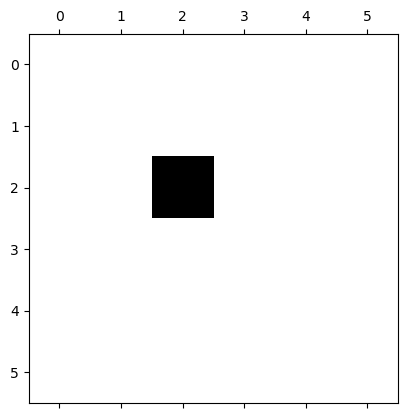

In [67]:
# Define the symbols used in the matrix
R12, R14, R23, R25, R36, R45, R56 = symbols('R12 R14 R23 R25 R36 R45 R56')
K_A, K_R, gamma3, gamma4, gamma5, delta = symbols('K_A K_R gamma_3 gamma_4 gamma_5 delta')
n3, n4, n5, P = symbols('n3 n4 n5 P')

# Define A, B, and C as per the provided equations
A = -R36 + gamma3 - (2 * gamma3 * n3) / K_A - (gamma3 * n4) / K_A - (gamma3 * n5) / K_A - delta
B = -R45 + gamma4 - (gamma4 * n3) / K_R - (2 * gamma4 * n4) / K_R - (gamma4 * n5) / K_R - delta
C = -R56 + gamma5 - (gamma5 * n3) / K_R - (gamma5 * n4) / K_R - (2 * gamma5 * n5) / K_R - delta

# Define the matrix J
J = Matrix([
    [-R12 - R14, 0, 0, 0, 0, 0],
    [R12, -R23 - R25, 0, 0, 0, 0],
    [0, R23, A, -gamma3 * n3 / K_A, -gamma3 * n3 / K_A, 0],
    [R14, 0, -gamma4 * n4 / K_R, B, -gamma4 * n4 / K_R, 0],
    [0, R25, -gamma5 * n5 / K_R, R45 - gamma5 * n5 / K_R, C, 0],
    [0, 0, R36 - R36 * P, 0, R56 - R56 * P, -R56 * n5 - R36 * n3]
])

# Display the original matrix J
# print("Matrix J:", J)

# Substitute n3, n4, n5, and P = 0 into the matrix (1st equilibrium points)
J_equilibrium = J.subs({n3: 0, n4: 0, n5: 0, P: 0})

# Display the evaluated matrix
# print("Evaluated Matrix J:", J_equilibrium)

J_result = np.array(J_equilibrium.subs(values).tolist(), dtype=float)

# compute sensitivity and elasticity matrix
l_right, v_right = sortEig(J_result)
v_right_max = v_right[:,-1]

l_left, v_left = sortEig(np.transpose(J_result))
v_left_max = v_left[:,-1]

np.set_printoptions(precision=4)
S = np.outer(v_left_max,v_right_max) / np.dot(v_left_max,v_right_max)
print("sensitivities matrix S =\n", np.real(S))

max_value_S = np.max(S)
max_position_S = np.unravel_index(np.argmax(S), S.shape)

print("Max Value:", max_value_S)
print("Max Position:", max_position_S)

E = S * J_result / l_left[-1]
print("elasticities matrix E =\n", np.real(E))

max_value_E = np.max(E)
max_position_E = np.unravel_index(np.argmax(E), E.shape)

print("Max Value:", max_value_E)
print("Max Position:", max_position_E)
plt.spy(np.real(E))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Max Value: 1.0
Max Position: (2, 2)
elasticities matrix E =
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Max Value: (1+0j)
Max Position: (2, 2)


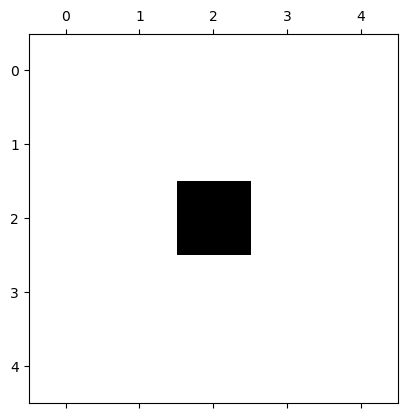

In [132]:
N_crypts = 1e+7
r1 = 204
u = 10e-7
mu = 10e-9
gamma3 = 0.2
gamma4 = 0.07
gamma5 = 0.07
delta = 0.05
KA = 1000
KR = 17

R12 = 2*u
R14 = mu
R23 = u
R25 = mu
R36 = mu
R45 = 2*u 
R56 = u


# define the matrix A
A = np.array([
    [1 - (R12 + R14), 0, 0, 0, 0],
    [R12, 1-(R23 + R25), 0, 0, 0],
    [0, R23, (1-R36)+gamma3-delta, 0, 0],
    [R14, 0, 0, (1-R45)+gamma4-delta, 0],
    [0, R25, 0, R45, (1-R56)+gamma5-delta]
])

l,v = la.eig(A)

idx=np.argsort(np.abs(l))
l_sorted=l[idx]  
v_sorted=v[:,idx]   #rearrange eigenvectors in same order
lambda_max= l_sorted[-1] #dom eigenvalue
v_max = v_sorted[:,-1] #dom eigenvector

l,v_left = la.eig(np.matrix.transpose(A))
idx=np.argsort(np.abs(l))
l_sorted=l[idx]
v_left_sorted=v_left[:,idx]   #rearrange eigenvectors in same order
v_left_max = v_left_sorted[:,-1]

As = np.outer(v_left_max,v_max)/np.dot(v_left_max,v_max)

np.set_printoptions(precision=3,suppress=True)
print(np.real(As))  #that real is just to nicely format the output here

max_value_As = np.max(As)
max_position_As = np.unravel_index(np.argmax(As), As.shape)

print("Max Value:", max_value_As)
print("Max Position:", max_position_As)

E = A * As / lambda_max
print("elasticities matrix E =\n", np.real(E))

max_value_E = np.max(E)
max_position_E = np.unravel_index(np.argmax(E), E.shape)

print("Max Value:", max_value_E)
print("Max Position:", max_position_E)
plt.spy(np.real(E))